Diagnóstico del cáncer de seno usando kNN
===

* 9:18 min | Ultima modificación: Abril 14, 2021 | [YouTube](https://youtu.be/nJ19K9_MduE)

**Bibliografía.**
* Machine Learning with R. Brett Lantz, Packt Publishing, Second Edition, 2015.

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Descripción del problema

Se desea determinar si una masa mamaria es un tumor benigno o maligno, a partir de las medidas obtenidas de imágenes digitalizadas de la aspiración con una aguja fina. Los valores representan las características de los núcleos celulares presentes en la imagen digital. La muestra de 569 ejemplos de resultados de las biopsias. Cada registro contiene 32 variables, las cuales corresponden a tres medidas (media, desviación estándar, peor caso) de diez características diferentes (radius, texture, ...).

* Identification number
* Cancer diagnosis ("M" para maligno y "B" para benigno)
* Radius
* Texture
* Perimeter
* Area
* Smoothness
* Compactness
* Concavity
* Concave points
* Symmetry
* Fractal dimension

En términos de los datos, se desea pronosticar si una masa es benigna o maligna (clase B o M) a partir de las 30 variables.

Fuente de los datos: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

El problema en términos matemáticos se define de la siguiente forma. 

* Se tienen $M$ ejemplos (las 569 observaciones del problema analizado).  
* Cada ejemplo esta definido por un conjunto de variables ($x_1$, $x_2$, ..., $x_N$); es decir, las 30 columnas de datos.
* Cada ejemplo pertenece a una clase y hay $P$ clases diferentes; en el caso analizado sólo hay dos clases: benigno o maligno. 
* Para un nuevo caso (tumor) y con base en las 30 mediciones realizadas (variables), se desea pronosticar a que clase pertenece (maligno o benigno). 

## Carga de datos

In [2]:
import pandas as pd

df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/wisc_bc_data.csv",
    sep=",",
    thousands=None,
    decimal=".",
    encoding="latin-1",
)

#
# Verificación de los datos cargados
#  La columna diagnosis corresponde al dianóstico.
#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave_points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

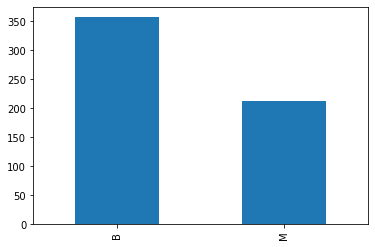

In [3]:
#
# Cantidad de casos para cada diagnóstico.
#
df.diagnosis.value_counts().plot.bar();

In [4]:
#
# Cantidad de casos para cada diagnóstico.
#
df.diagnosis.value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [5]:
#
# Probabilidades.
#
round(100 * df.diagnosis.value_counts() / sum(df.diagnosis.value_counts()), 1)

B    62.7
M    37.3
Name: diagnosis, dtype: float64

In [6]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
#
# Extrae la columna diagnosis que es la
# variable de salida (columna 1)
#
y = df.diagnosis

#
# Elimina las columnas 0 (id) y 1 (diagnosis)
#  de los datos originales
#
X = df.iloc[:, 2:]
X.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Preparación de los datos

In [8]:
#
#  se examina el rango de las variables
#
X.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


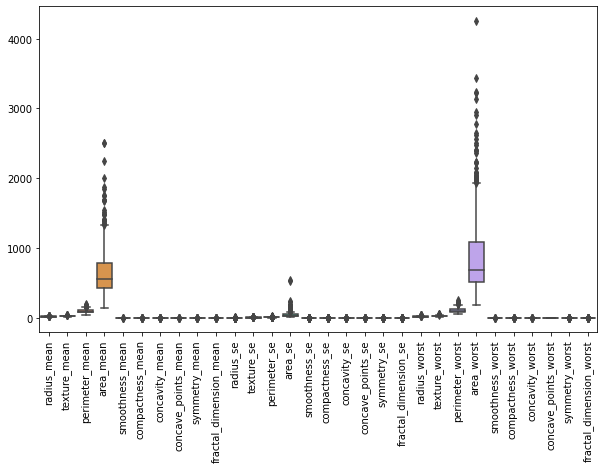

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=X)
plt.xticks(rotation=90);

Note que la información visualizada muestra que las variables tienen diferentes rangos, lo que afecta la medición de las distancias, y habría variables que pesarían más en la medición respecto a otras. Para corregir este problema se normalizan las variables.

In [10]:
#
# Escala la matriz de datos al intervalo [0, 1]
#
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[0.52103744, 0.0226581 , 0.54598853, ..., 0.91202749, 0.59846245,
        0.41886396],
       [0.64314449, 0.27257355, 0.61578329, ..., 0.63917526, 0.23358959,
        0.22287813],
       [0.60149557, 0.3902604 , 0.59574321, ..., 0.83505155, 0.40370589,
        0.21343303],
       ...,
       [0.45525108, 0.62123774, 0.44578813, ..., 0.48728522, 0.12872068,
        0.1519087 ],
       [0.64456434, 0.66351031, 0.66553797, ..., 0.91065292, 0.49714173,
        0.45231536],
       [0.03686876, 0.50152181, 0.02853984, ..., 0.        , 0.25744136,
        0.10068215]])

## Entrenamiento del modelo

In [11]:
#
# Se crean los conjuntos de entrenamiento y prueba
#
X_train = X_scaled[:468]
X_test = X_scaled[468:]
y_train_true = y[:468]
y_test_true = y[468:]

#
# Se construye el clasificador
#
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train_true)

#
# Predicción para el conjunto de prueba
#
y_test_pred = knn.predict(X_test)
y_test_pred

array(['M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B',
       'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'M', 'B', 'B', 'B',
       'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B',
       'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',
       'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'M', 'B'], dtype=object)

## Evaluación del modelo

Para evaluar el desempeño en problemas de clasificación dicotómicos (dos clases mutuamente excluyentes) se usa la siguiente tabla:


             | Pronostico
             |  P     N
    ---------|------------  
          P  |  TP    FN          
    Real     |
          N  |  FP    TN
    
    TP - Verdadero positivo (correcto)
    TN - Verdadero negativo (correcto)
    FN - Falso negativo (mal clasificado)
    FP - Falso positivo (mal clasificado)
    
La medición de la precisión del modelo permite estimar el desempeño del modelo ante nuevos datos.

In [12]:
#
# Métricas de desempeño
#
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_true, y_test_pred)

array([[77,  0],
       [ 2, 22]])

* Tasa de éxito (porcentaje de patrones clasificados correctamente):


$$\text{success rate} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

* Tasa de error (porcentaje de patrones clasificados incorrectamente):

$$\text{error rate} = \frac{\text{FP} + \text{FN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} = 1 - \text{accuracy}$$

* Predominio: número total de casos positivos pronósticados respecto al número total de casos.


$$\text{prevalence} = \frac{\text{TP} + \text{FN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

* Sensibilidad, tasa verdadera positiva, recall, sensibilidad: mide la proporción de ejemplos positivos que fueron correctamente clasificados.


$$\text{sensitibity} = \frac{\text{TP}}{\text{TP}  + \text{FN}}$$

* Especifidad o tasa verdadera negativa: mide la proporción de ejemplos negativos correctamente clasificados.


$$\text{specifity} = \frac{\text{TN}}{\text{TN}  + \text{FP}}$$

* Precisión o valor predictivo positivo: Proporción de casos positivos que fueron verdaderamente positivos.


$$\text{precision} = \frac{\text{TP}}{\text{TP}  + \text{FP}}$$

* Valor predictivo negativo: Proporción de casos negativos que fueron verdaderamente negativos.


$$\text{negative predictive value} = \frac{\text{TN}}{\text{TN}  + \text{FN}}$$

* La medida F permite comparar varios modelos entre si, combinando la precisión y el recall en una sola medida.


$$\text{F-measure} = \frac{2 * \text{TP}}{2 * \text{TP} + \text{FP} + \text{FN}}$$

In [13]:
#
# Métricas de desempeño para clasificadores binarios
#
def scoring(y_true, y_pred):

    from sklearn.metrics import confusion_matrix

    import pandas as pd

    tn, fp, fn, tp = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred).ravel()
    success_rate = (tp + tn) / (tp + tn + fp + fn)
    error_rate = (fp + fn) / (tp + tn + fp + fn)
    prevalence = (tp + fn) / (tp + tn + fp + fn)
    sensitibity = tp / (tp + fn)
    specifity = tn / (tn + fp)
    precision = tp / (tp + fp)

    score = pd.Series(
        data=[
            tn,
            fp,
            fn,
            tp,
            success_rate,
            error_rate,
            prevalence,
            sensitibity,
            specifity,
            precision,
            success_rate,
        ],
        index=[
            "tn",
            "fp",
            "fn",
            "tp",
            "success_rate",
            "error_rate",
            "prevalence",
            "sensitibity",
            "specifity",
            "precision",
            "accuracy",
        ],
    )
    return score


scoring(y_test_true, y_test_pred)

tn              77.000000
fp               0.000000
fn               2.000000
tp              22.000000
success_rate     0.980198
error_rate       0.019802
prevalence       0.237624
sensitibity      0.916667
specifity        1.000000
precision        1.000000
accuracy         0.980198
dtype: float64

In [14]:
#
# Reporte de precisión del clasificador
#
from sklearn.metrics import classification_report

print(classification_report(y_true=y_test_true, y_pred=y_test_pred))

              precision    recall  f1-score   support

           B       0.97      1.00      0.99        77
           M       1.00      0.92      0.96        24

    accuracy                           0.98       101
   macro avg       0.99      0.96      0.97       101
weighted avg       0.98      0.98      0.98       101



## Mejora del modelo

**Ejercicio.---** Determine si el modelo mejora con $k$ = 21 y se estándarizan las variables (use la función `scale`). 

**Ejercicio.--** Determine el valor óptimo de $k$ cuándo los datos son normalizados (Calcule la cantidad total de ejemplos mal clasificados para $k$ desde 1 hasta 27).

**Ejercicio.---** Los resutados son dependientes de cómo se partieron los datos en entrenamiento y prueba. Cómo podría calcular de una forma más robusta la cantidad de vecinos?